# solucionando incompatibilidades

# 1) problema, no puedo usar las LSTM, por lo que recomiendan :
El error que estás viendo se debe a que la operación `CudnnRNN` no puede encontrar un kernel compatible para ejecutarse en tu configuración actual. Esto es común cuando TensorFlow no puede encontrar la versión correcta de CUDA/cuDNN o cuando hay un problema de compatibilidad.

Aquí tienes algunos pasos que puedes seguir para solucionar este problema:

### 1. Verificar la Instalación de CUDA y cuDNN

Asegúrate de tener instalada una versión de CUDA y cuDNN que sea compatible con tu versión de TensorFlow. Puedes consultar la tabla de compatibilidad en la [guía de instalación de TensorFlow](https://www.tensorflow.org/install/gpu).

Para verificar la versión de CUDA y cuDNN instalada, puedes ejecutar los siguientes comandos:

```sh
nvcc --version
```

y para cuDNN, verifica el archivo `cudnn.h` que suele estar en el directorio de instalación de CUDA.

### 2. Verificar la Disponibilidad de la GPU

Asegúrate de que TensorFlow puede ver y utilizar tu GPU. Ejecuta el siguiente código para verificar:

```python
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
```

### 3. Forzar el Uso de Implementaciones de CPU

Si no necesitas usar GPU, puedes forzar a TensorFlow a usar las implementaciones de CPU en lugar de `CudnnRNN`:

```python
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
```

### 4. Desactivar `CudnnRNN` para LSTM

Puedes intentar usar la implementación estándar de LSTM en lugar de `CudnnRNN` configurando el parámetro `use_bias=False` y `recurrent_initializer='glorot_uniform'` en tus capas LSTM. Aquí hay un ejemplo modificado de tu código:

```python
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

# Datos de ejemplo
X_train = np.random.random((100, 10, 5))  # 100 muestras, secuencias de longitud 10, 5 características
y_train = np.random.randint(0, 3, 100)   # 100 etiquetas, 3 clases
y_train = tf.keras.utils.to_categorical(y_train, 3)  # One-hot encoding de las etiquetas

# Definir la función para crear el modelo con regularización L1 y L2
def create_model(optimizer='adam', neurons=300, dropout_rate=0.2, l1_reg=0.01, l2_reg=0.01):
    model = Sequential()
    model.add(LSTM(neurons,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True,
                   kernel_regularizer=l2(l2_reg),  # pesos
                   bias_regularizer=l2(l2_reg),    # sesgos
                   recurrent_initializer='glorot_uniform'))  # Para evitar CudnnRNN
    model.add(Dropout(dropout_rate))  # Dropout para regularización
    model.add(LSTM(neurons//2,
                   kernel_regularizer=l2(l2_reg),
                   bias_regularizer=l2(l2_reg),
                   recurrent_initializer='glorot_uniform'))  # Para evitar CudnnRNN
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons//4, activation='relu',
                    kernel_regularizer=l2(l2_reg),
                    bias_regularizer=l2(l2_reg)))
    model.add(Dense(X_train.shape[2], activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo con las regularizaciones especificadas
model = create_model()

# Early stopping para detener el entrenamiento si no hay mejora significativa
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=2, batch_size=29, validation_split=0.17, callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Loss: {loss}, Accuracy: {accuracy}')
```

### 5. Verificar los Drivers de la GPU

Asegúrate de que los drivers de la GPU estén actualizados. Puedes actualizar los drivers desde el sitio web del fabricante de tu GPU (NVIDIA en la mayoría de los casos).

### 6. Actualizar TensorFlow

Asegúrate de tener la última versión de TensorFlow instalada. Puedes actualizar TensorFlow con el siguiente comando:

```sh
pip install --upgrade tensorflow
```

Siguiendo estos pasos, deberías poder resolver el problema con las capas LSTM y evitar el error relacionado con `CudnnRNN`. Si el problema persiste, por favor proporciona más detalles sobre tu entorno de desarrollo para que pueda ayudarte mejor.

### INICIO

In [1]:
!pip install keras-tuner
!pip install pydot graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [2]:
!pip install scikit-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 3.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/rps2')

from Mi_ML import *

Mounted at /content/drive


In [4]:
# desde cero hacemos uno nuevo. la logica de programacion mas engorrosa ya esta dentro de fucniones a compilar
# por lo que nos centraremos en terminar un modelo simple y luego a posterior lo empaquetamos en una clase con utilidades, otra nueva con muchas funciones a reutilizar
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split #TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
%matplotlib inline



In [5]:
from Mi_ML import *
from RPS_game import *

In [6]:
comb = inicio_RPSgame()
secuenc = 10
X, y = Secuencial_OneHot(comb, secuenc) # ira en secuencias de 5 por l otanto, 5 filas de ceros# tenemso los datos de X e y

quin :  ['R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', 'S', 'R', 'R', 'P', 'P', '

### entrenamiento y creacion del modelo

In [8]:
comb

array(['R', 'P', 'P', ..., 'R', 'R', 'R'], dtype='<U1')

In [9]:
# Entrenamos los datos para conseguir datos de train y test, usaremos la clasica de
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42) # probamos sin el shuffle false

In [ ]:
# entrenamos un modelo bien basico con tensorflow, uno de LSTM el mejor que hicimos
# este estaba empaquetado en una funcion

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

# Definir la función para crear el modelo con regularización L1 y L2
# def create_model(optimizer='adam', neurons=300, dropout_rate=0.2, l1_reg=0.01, l2_reg=0.01):
#     model = Sequential()
#     model.add(LSTM(neurons,
#                    input_shape=(X_train.shape[1], X_train.shape[2]),
#                    return_sequences=True,
#                    kernel_regularizer=l2(l2_reg/2),  # pesos
#                    bias_regularizer=l2(l2_reg))) # sesgos
#     model.add(Dropout(dropout_rate))  # Dropout para regularización
#     # model.add(BatchNormalization())  # Normalización por lotes
#     model.add(LSTM (neurons//2,
#                    kernel_regularizer=l2(l2_reg),
#                    bias_regularizer=l2(l2_reg/2)))
#     model.add(Dropout(dropout_rate/2))

#     # model.add(Dense(neurons//4, activation='relu', # la comentamos temporalmente
#     #                 kernel_regularizer=l2(l2_reg),
#     #                 bias_regularizer=l2(l2_reg)))
#     model.add(Dense(X_train.shape[2], activation='softmax'))

#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GlobalAveragePooling1D
# Comenzamos con las GRU
def create_model(optimizer='adam', neurons=500, dropout_rate=0.2, l1_reg=0.01, l2_reg=0.01): # "Mejorada" usaremos
    model = Sequential()
    model.add(GRU(neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    #model.add(BatchNormalization())
    model.add(GRU(neurons, return_sequences=True))
    model.add(Dropout(dropout_rate//1.5))
    model.add(BatchNormalization()) # Añadir capas de Batch Normalization puede ayudar a estabilizar y acelerar el entrenamiento
    model.add(GlobalAveragePooling1D()) # Después de la capa LSTM, puedes usar capas de pooling (por ejemplo, GlobalAveragePooling1D) para reducir la dimensionalidad de las secuencias.
    model.add(Dense(neurons//3, activation='relu'))
    model.add(Dropout(dropout_rate//2))
    model.add(Dense(X_train.shape[2], activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Crear el modelo con las regularizaciones especificadas
model = create_model()

# Early stopping para detener el entrenamiento si no hay mejora significativa
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Entrenar el modelo
# with tf.device('/device:GPU:0'):
history = model.fit(X_train, y_train, epochs=35, batch_size=30, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/35
  62/1024 [>.............................] - ETA: 3:22 - loss: 1.1260 - accuracy: 0.4242

KeyboardInterrupt: 

In [ ]:
NAME = "3_8del7_GRU_puro"
model.save(f"{NAME}.h5")
# clave. lo del tema delshufle en time split de sklearn, arriba, tiene que ser por defecto, true para que generalice mejor el modelo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


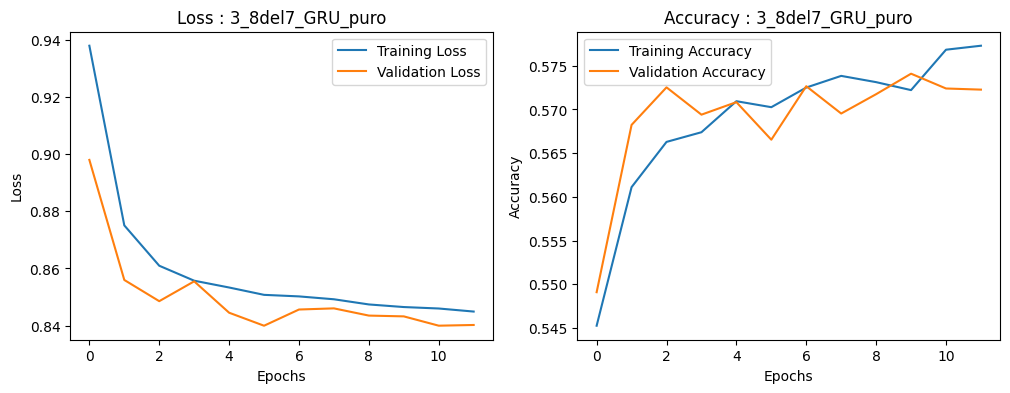

In [ ]:
# vamos a ver que tan bien generalzia el modelo ahora

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss : {NAME}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy : {NAME}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
print(NAME)
print(model.summary())

3_8del7_GRU_puro
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 500)            757500    
                                                                 
 dropout_6 (Dropout)         (None, 5, 500)            0         
                                                                 
 gru_1 (GRU)                 (None, 5, 500)            1503000   
                                                                 
 dropout_7 (Dropout)         (None, 5, 500)            0         
                                                                 
 batch_normalization (Batch  (None, 5, 500)            2000      
 Normalization)                                                  
                                                                 
 global_average_pooling1d (  (None, 500)               0         
 GlobalAveragePooling1D)             

In [ ]:
model.evaluate(X_test,y_test)

300/300 [==============================] - 2s 5ms/step - loss: 0.8356 - accuracy: 0.5696


[0.8355715870857239, 0.5696426630020142]

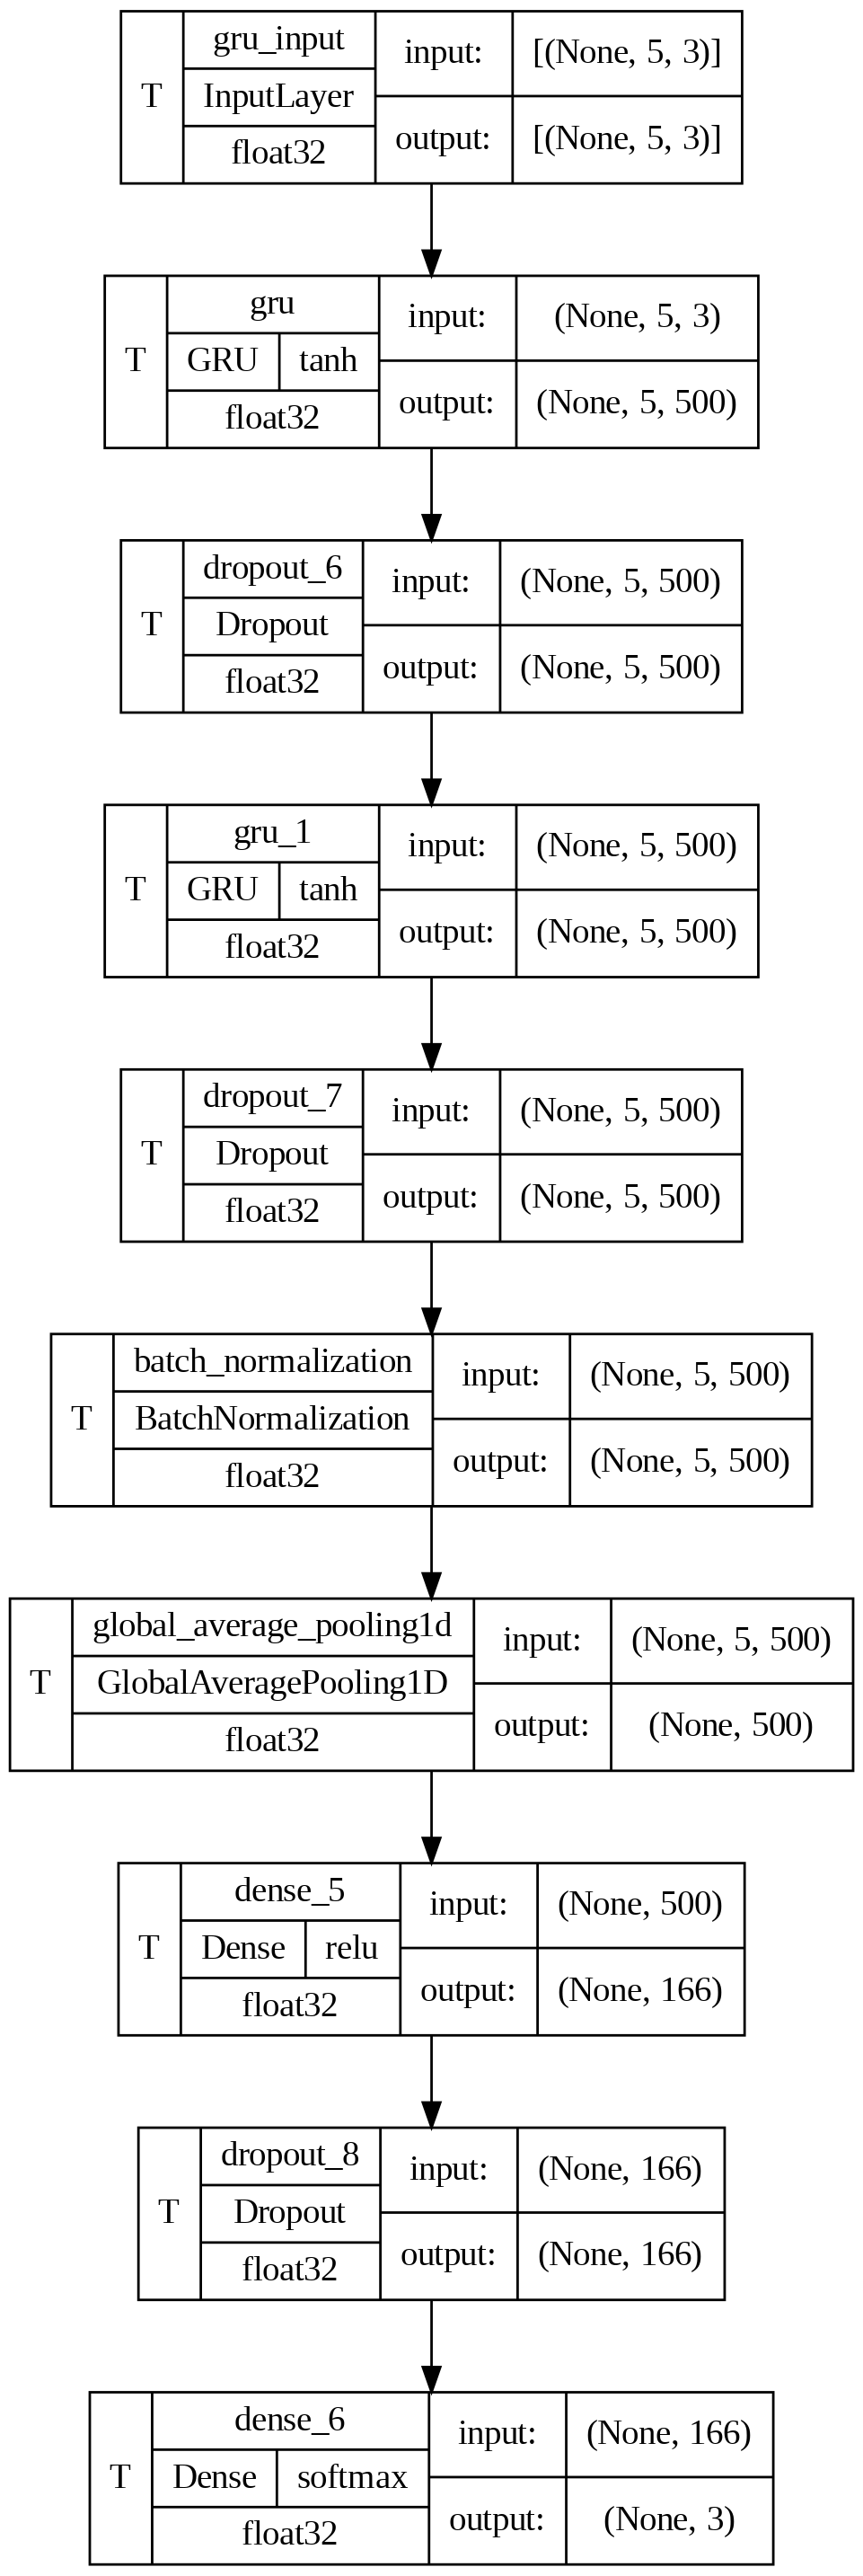

In [ ]:
# Generamos un diagrama del modelo
# Generar el diagrama del modelo
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
plot_model(model, to_file=f'{NAME}.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,) # asi visualizamos mejor la arquitectura de capas y documentamos mejor el progreso

In [ ]:
# o le faltaron epocas ? que ssera ?
# la precicion es alta , pero el modelo se entreno poco, sera que estara mal entrenado. hay que testearlo con los bots

# ajustamos para tener la funcion de player correcpondiente
#import numpy as np
#import tensorflow as tf
# from tensorflow.keras.models import load_model

# Mapeo de índices a etiquetas
label_map = {0: 'P', 1: 'R', 2: 'S'}

def rps_one_hot_single(play):
    if play == 'P':
        return [1, 0, 0]
    elif play == 'R':
        return [0, 1, 0]
    elif play == 'S':
        return [0, 0, 1]


def AI_player5(prev_play, opponent_history=[]): # la variable a poner aca seria sequence_leght
    if prev_play == '':
        prev_play = 'R'  # Valor predeterminado inicial

    opponent_history.append(prev_play)

    sequence_length = secuenc
    if len(opponent_history) < sequence_length:
        return 'R'  # Valor predeterminado si no hay suficientes datos

    input_sequence = opponent_history[-sequence_length:]
    one_hot_sequence = [rps_one_hot_single(play) for play in input_sequence]

    input_sequence = np.array(one_hot_sequence, dtype=np.float32)
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Añadir dimensión de batch

    prediccion = model.predict(input_sequence, verbose=0)
    prediccion_label = np.argmax(prediccion, axis=-1)[0]

    label_map = {0: 'P', 1: 'R', 2: 'S'}
    predicted_move = label_map[prediccion_label]

    # Lógica para ganar el juego:
    if predicted_move == 'R':
        return 'P'  # Papel gana a piedra
    elif predicted_move == 'P':
        return 'S'  # Tijeras ganan a papel
    elif predicted_move == 'S':
        return 'R'  # Piedra gana a tijeras

# Funciono


In [ ]:
# a jugar !
from RPS_game import play, mrugesh, abbey, quincy, kris, human, random_player
from RPS1 import player
from unittest import main

with tf.device('/device:GPU:0'):
  play(AI_player5, quincy, 1000)
  play(AI_player5, abbey, 1000)
  play(AI_player5, kris, 1000)
  play(AI_player5, mrugesh, 1000)

Final results: {'p1': 997, 'p2': 2, 'tie': 1}
Player 1 win rate: 99.7997997997998%
Final results: {'p1': 236, 'p2': 354, 'tie': 410}
Player 1 win rate: 40.0%
Final results: {'p1': 236, 'p2': 354, 'tie': 410}
Player 1 win rate: 40.0%
Final results: {'p1': 808, 'p2': 192, 'tie': 0}
Player 1 win rate: 80.80000000000001%


In [ ]:
# tenemos que ver la manera de implementar una optimizacion de hyperparametros # Todas con fhufle == true
""" - - - -- 1_8del7_SIMPLE_RNN:
Final results: {'p1': 997, 'p2': 2, 'tie': 1}
Player 1 win rate: 99.7997997997998%
Final results: {'p1': 2, 'p2': 499, 'tie': 499}
Player 1 win rate: 0.39920159680638717%
Final results: {'p1': 300, 'p2': 698, 'tie': 2}
Player 1 win rate: 30.060120240480963%
Final results: {'p1': 705, 'p2': 292, 'tie': 3}
Player 1 win rate: 70.71213640922768%
"""

# ahora vamos con puras LSTM y al final una dense
"""
>>> 1_8del7_LSTM_y_una_dense:
Final results: {'p1': 997, 'p2': 2, 'tie': 1}
Player 1 win rate: 99.7997997997998%
Final results: {'p1': 434, 'p2': 391, 'tie': 175}
Player 1 win rate: 52.6060606060606%
Final results: {'p1': 228, 'p2': 546, 'tie': 226}
Player 1 win rate: 29.457364341085274%
Final results: {'p1': 771, 'p2': 229, 'tie': 0}
Player 1 win rate: 77.10000000000001%
"""

"""
3-_LSTM PURo

- mejoro un poco en ambos casi llega los 40 en ambos datos, aprendio de patrones mas complejos

Final results: {'p1': 997, 'p2': 2, 'tie': 1}
Player 1 win rate: 99.7997997997998%
Final results: {'p1': 374, 'p2': 623, 'tie': 3}
Player 1 win rate: 37.512537612838514%
Final results: {'p1': 374, 'p2': 625, 'tie': 1}
Player 1 win rate: 37.43743743743744%
Final results: {'p1': 770, 'p2': 227, 'tie': 3}
Player 1 win rate: 77.23169508525577%

GRU PURO : creo que por le momento es el mejor por lo que vamos a ver si podemos hacer

Final results: {'p1': 997, 'p2': 2, 'tie': 1}
Player 1 win rate: 99.7997997997998%
Final results: {'p1': 236, 'p2': 354, 'tie': 410}
Player 1 win rate: 40.0%
Final results: {'p1': 236, 'p2': 354, 'tie': 410}
Player 1 win rate: 40.0%
Final results: {'p1': 808, 'p2': 192, 'tie': 0}
Player 1 win rate: 80.80000000000001%

""" # creo que este es el mejor




SyntaxError: incomplete input (<ipython-input-26-d737edd9b8d0>, line 14)

### informacion importante, dada la eficiencia computacional usaremos las GRU ya que intentamos predecir secuencias simples. R P S. Ademas segun entendi las GRU tienen un rendimiento similar a las LSTM pero con mucha mejor  eficiencia computacional de entrenamiento.

porque usamos GRU : por su rendimiento, y porque necesitamos un modelo para predecir secuencias simples, elegimos las GRU por su rendimiento similar a las LSTM pero con un mejor rendimiento en el entrenamiento y evaluacion


porque usamos las Global Average Pooling 1D  y batch normalization? por su disminucion de dimensionalidad.

Batch Normalization
BatchNormalization es una técnica que mejora el rendimiento y la estabilidad de las redes neuronales. Aquí hay una explicación detallada de lo que hace y por qué es útil:

Normalización de los Datos de Entrada:

¿Qué hace?: Normaliza la salida de la capa anterior para que tenga una media de 0 y una desviación estándar de 1.

Beneficio: Reduce significativamente el número de parámetros en el modelo, lo que puede ayudar a prevenir el sobreajuste.
Efecto: Simplifica la estructura del modelo antes de pasar a capas densas, permitiendo una representación más compacta de las características aprendidas.
